# Download Dataset

In [1]:
import os

# to be changed to your own username / password
os.environ['KAGGLE_USERNAME'] = 'user'
os.environ['KAGGLE_KEY'] = 'password'

!kaggle datasets download cosmos98/twitter-and-reddit-sentimental-analysis-dataset

 50% 5.00M/10.0M [00:00<00:00, 14.1MB/s]
100% 10.0M/10.0M [00:00<00:00, 25.4MB/s]


In [2]:
!unzip twitter-and-reddit-sentimental-analysis-dataset.zip

Archive:  twitter-and-reddit-sentimental-analysis-dataset.zip
  inflating: Reddit_Data.csv         
  inflating: Twitter_Data.csv        


# Load to Pandas

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

reddit_file = 'Reddit_Data.csv'
twitter_file = 'Twitter_Data.csv'

SEED = 42

def load(data_file, text_col):
    df = pd.read_csv(data_file)
    df = df[(df['category'].notna()) & (df[text_col].notna())]
    df['text'] = df[text_col]
    return df[['text', 'category']]

def load_reddit_data():
    return load(reddit_file, 'clean_comment')

def load_twitter_data():
    return load(twitter_file, 'clean_text')

def load_data():
    df = pd.concat([load_reddit_data(), load_twitter_data()])
    df_train, df_test = train_test_split(df, test_size=0.8, random_state=SEED)
    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=SEED)
    return df_train, df_val, df_test

In [4]:
df_train, df_val, df_test = load_data()

In [5]:
df_train

,text,category
106053,party name appeal for votes may give clean chi...,1.0
5277,thanks lot bjp thanks for the acche din move ...,1.0
57789,had doubts what impact addressing the nation f...,1.0
40337,trolls have field day modi biopic trailer rages,0.0
2717,mai bhi chowkidar only bjp jai hind jai modi v...,0.0
...,...,...
58729,india becoming the fourth space super power ph...,1.0
145444,you want saying that modi brought the kiya mot...,0.0
4698,yes the time has come\nbut 1st have receive ₹ ...,0.0
128160,where from the money for ayushman bharat yogan...,1.0


In [35]:
df_train[df_train['category'] == 1.0].sample(5)

,text,category
59426,btw heard soon after modi tweeted that coming ...,1.0
11287,one more proof paper these buggers live with c...,1.0
28110,shouldnt that guy jail right now and hes conte...,1.0
29864,this man will change the course our nation for...,1.0
118398,seems some undercurrent already started buildi...,1.0


In [38]:
df_train[df_train['category'] == 0].sample(5)

,text,category
48418,modi found any such institution his 5year turn,0.0
157097,after playing the pakistan card often even cla...,0.0
28118,but appreciate the work modi,0.0
36331,you deserve modi,0.0
101461,narendra modi not poot the constitutional fath...,0.0


In [39]:
df_train[df_train['category'] == -1.0].sample(5)

,text,category
13152,critisize the nation dance desh tere kitne tuk...,-1.0
34326,according wikipedia there was case filed about...,-1.0
155444,discard bjp before india becomes failed state ...,-1.0
129301,acrd 27lakh govt job got vacant yrs bsnl air i...,-1.0
78554,the brink failure modi sinks lower,-1.0


In [6]:
# It seems that positive = 1 and negative = -1 and neutral = 0

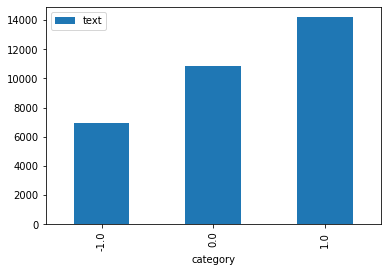

In [41]:
df_train.groupby('category').count().plot.bar()

In [19]:
import numpy as np
import tensorflow as tf

# convert to one hot
# positive = [0, 0, 1], negative = [1, 0, 0], neutral = [0, 1, 0]
def to_one_hots(y_vals):
    y = (y_vals + 1).astype(int)
    return (
        np.eye(
            np.max(y) + 1
        )[y]
    ).astype(int)

def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices(
        (df['text'].values, to_one_hots(df['category'].values))
    )

In [20]:
train_ds, val_ds = [df_to_ds(df) for df in [df_train, df_val]]

BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)

val_ds = val_ds.padded_batch(BATCH_SIZE)

In [22]:
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_nnlm_model():
    embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
    hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                            dtype=tf.string, trainable=True)
    
    model = tf.keras.Sequential([
        hub_layer,
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(5e-5),
              metrics=['accuracy'])
    return model

In [23]:
model = create_nnlm_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 124,653,123
Trainable params: 124,653,123
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(
    train_ds, validation_data=val_ds, validation_steps=30, epochs=5
)

Epoch 1/5
1001/1001 [==============================] - 73s 73ms/step - loss: 1.0550 - accuracy: 0.4551 - val_loss: 1.0207 - val_accuracy: 0.5125
Epoch 2/5
1001/1001 [==============================] - 73s 73ms/step - loss: 0.9670 - accuracy: 0.6040 - val_loss: 0.9378 - val_accuracy: 0.6281
Epoch 3/5
1001/1001 [==============================] - 73s 73ms/step - loss: 0.8905 - accuracy: 0.6788 - val_loss: 0.8832 - val_accuracy: 0.6771
Epoch 4/5
1001/1001 [==============================] - 73s 73ms/step - loss: 0.8351 - accuracy: 0.7254 - val_loss: 0.8400 - val_accuracy: 0.7219
Epoch 5/5
1001/1001 [==============================] - 73s 73ms/step - loss: 0.7827 - accuracy: 0.7880 - val_loss: 0.8023 - val_accuracy: 0.7542


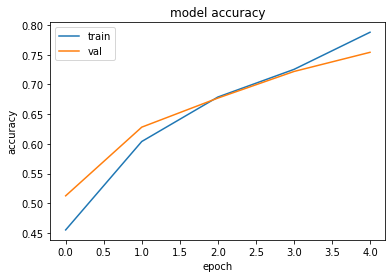

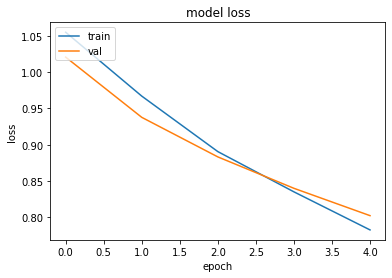

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
history1 = model.fit(
    train_ds, validation_data=val_ds, validation_steps=30, epochs=10
)

Epoch 1/10
1001/1001 [==============================] - 73s 73ms/step - loss: 0.7380 - accuracy: 0.8352 - val_loss: 0.7752 - val_accuracy: 0.7792
Epoch 2/10
1001/1001 [==============================] - 73s 73ms/step - loss: 0.7018 - accuracy: 0.8698 - val_loss: 0.7523 - val_accuracy: 0.7969
Epoch 3/10
1001/1001 [==============================] - 73s 73ms/step - loss: 0.6747 - accuracy: 0.8971 - val_loss: 0.7355 - val_accuracy: 0.8198
Epoch 4/10
1001/1001 [==============================] - 73s 73ms/step - loss: 0.6520 - accuracy: 0.9157 - val_loss: 0.7229 - val_accuracy: 0.8313
Epoch 5/10
1001/1001 [==============================] - 73s 73ms/step - loss: 0.6347 - accuracy: 0.9317 - val_loss: 0.7152 - val_accuracy: 0.8313
Epoch 6/10
1001/1001 [==============================] - 73s 73ms/step - loss: 0.6211 - accuracy: 0.9426 - val_loss: 0.7090 - val_accuracy: 0.8438
Epoch 7/10
1001/1001 [==============================] - 73s 73ms/step - loss: 0.6099 - accuracy: 0.9522 - val_loss: 0.7053 -

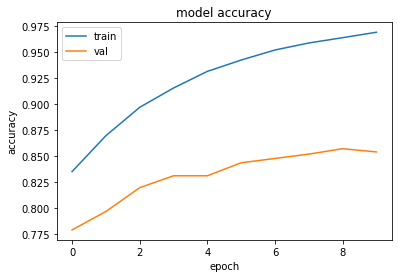

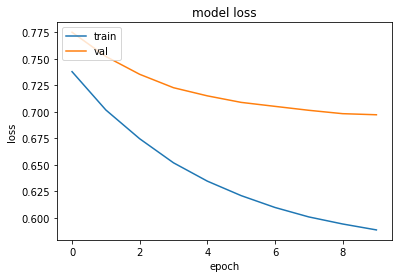

In [28]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
test_ds = df_to_ds(df_test)
test_ds = test_ds.padded_batch(BATCH_SIZE)

In [45]:
model.evaluate(test_ds)

5003/5003 [==============================] - 34s 7ms/step - loss: 0.6817 - accuracy: 0.8695


[0.6816648840904236, 0.8695150017738342]

In [32]:
model.predict(['Im not very happy']) # negative as expected

array([[1.4465879e-06, 3.5533659e-11, 9.9999857e-01]], dtype=float32)

In [42]:
model.predict(['im sooo very happpy']) # positive as expected

array([[9.081827e-01, 7.413144e-04, 9.107605e-02]], dtype=float32)

In [43]:
model.predict(['i have work to do']) # very neutral

array([[0.00327233, 0.9942239 , 0.0025038 ]], dtype=float32)

In [29]:
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [30]:
!zip -r model.zip model/

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/assets/tokens.txt (deflated 43%)
  adding: model/saved_model.pb (deflated 87%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 63%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 67%)
